## Autoencoders
#### By Ali Shannon

This simple code shows you how to make an autoencoder using Pytorch. The idea is to bring down the number of dimensions (or reduce the feature space) using neural networks.

The idea is simple, let the neural network learn how to make the encoder and the decoder using the feature space as both the input and the output of the network.

In [8]:
import torch
from torch import nn, optim
import numpy as np
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler

Here I am using the swiss roll example and reduce it from 3D to 2D

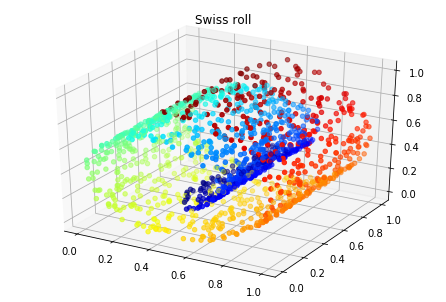

In [10]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

n_samples = 1500
noise = 0.05
X, colors = make_swiss_roll(n_samples, noise)

X = MinMaxScaler().fit_transform(X)

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2], c=colors, cmap=plt.cm.jet)
plt.title('Swiss roll')
plt.show()

In [38]:
x = torch.from_numpy(X).to(device)

class Autoencoder(nn.Module):
    """Makes the main denoising auto

    Parameters
    ----------
    in_shape [int] : input shape
    enc_shape [int] : desired encoded shape
    """

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape),
            nn.Linear(enc_shape, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
encoder = Autoencoder(in_shape=3, enc_shape=2).double().to(device)

error = nn.MSELoss()

optimizer = optim.Adam(encoder.parameters())

In [39]:
def train(model, error, optimizer, n_epochs, x):
    model.train()
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        output = model(x)
        loss = error(output, x)
        loss.backward()
        optimizer.step()
        
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

You can rerun this function or just increase the number of epochs. Dropout was added for denoising, otherwise it will be very sensitive to input variations.

In [42]:
train(encoder, error, optimizer, 5000, x)

epoch 500 	 Loss: 0.005198
epoch 1000 	 Loss: 0.004744
epoch 1500 	 Loss: 0.00462
epoch 2000 	 Loss: 0.004592
epoch 2500 	 Loss: 0.004379
epoch 3000 	 Loss: 0.004569
epoch 3500 	 Loss: 0.004541
epoch 4000 	 Loss: 0.004156
epoch 4500 	 Loss: 0.004557
epoch 5000 	 Loss: 0.004369


In [43]:
with torch.no_grad():
    encoded = encoder.encode(x)
    decoded = encoder.decode(encoded)
    mse = error(decoded, x).item()
    enc = encoded.cpu().detach().numpy()
    dec = decoded.cpu().detach().numpy()

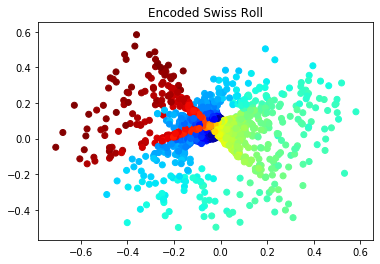

In [44]:
plt.scatter(enc[:, 0], enc[:, 1], c=colors, cmap=plt.cm.jet)
plt.title('Encoded Swiss Roll')
plt.show()

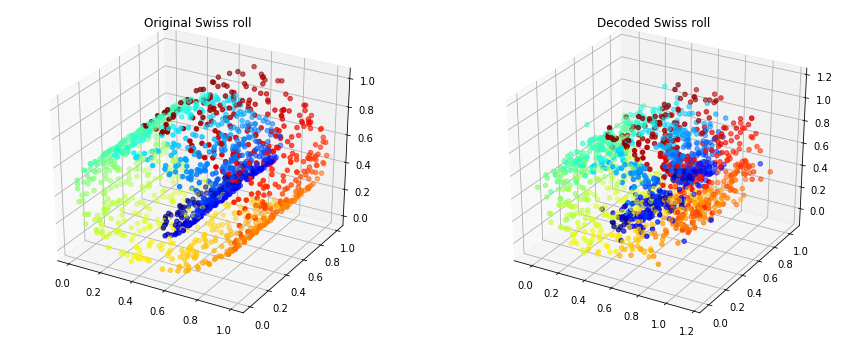

Root mean squared error: 0.06634


In [45]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=colors, cmap=plt.cm.jet)
plt.title('Original Swiss roll')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(dec[:,0], dec[:,1], dec[:,2], c=colors, cmap=plt.cm.jet)
plt.title('Decoded Swiss roll')
plt.show()

print(f'Root mean squared error: {np.sqrt(mse):.4g}')

Obviously there are some losses in variance due to the dimensionality reduction but this reconstruction is quite interesting. This is how the model reacts to another roll.

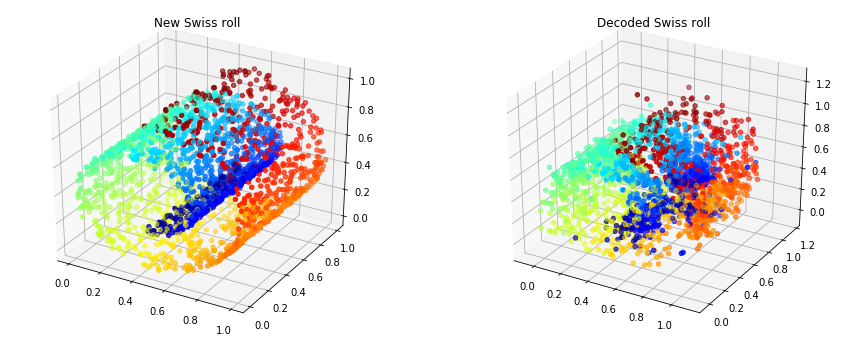

Root mean squared error: 0.08295


In [118]:
n_samples = 2500
noise = 0.1
X, colors = make_swiss_roll(n_samples, noise)

X = MinMaxScaler().fit_transform(X)

x = torch.from_numpy(X).to(device)

with torch.no_grad():
    encoded = encoder.encode(x)
    decoded = encoder.decode(encoded)
    mse = error(decoded, x).item()
    enc = encoded.cpu().detach().numpy()
    dec = decoded.cpu().detach().numpy()

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=colors, cmap=plt.cm.jet)
plt.title('New Swiss roll')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(dec[:,0], dec[:,1], dec[:,2], c=colors, cmap=plt.cm.jet)
plt.title('Decoded Swiss roll')
plt.show()

print(f'Root mean squared error: {np.sqrt(mse):.4g}')